# ***Imports and dataset generation***

---



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic dataset with fresh randomness each run
n = 100
x = np.random.rand(n)
noise = np.random.normal(0, 0.01, n)
y = np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x) + noise

# Split into 80/20 train/test
indices = np.arange(n)
np.random.shuffle(indices)
train_idx = indices[:int(0.8 * n)]
test_idx = indices[int(0.8 * n):]
x_train, y_train = x[train_idx], y[train_idx]
x_test, y_test = x[test_idx], y[test_idx]

# **Decision stump implementation**

---







In [2]:
class DecisionStump:
    def __init__(self, n_cuts=20):
        self.threshold = None
        self.left_value = None
        self.right_value = None
        self.n_cuts = n_cuts

    def fit(self, x, residuals, loss):
        best_err = float('inf')
        cuts = np.linspace(0, 1, self.n_cuts)
        for t in cuts:
            left_mask = x <= t
            right_mask = ~left_mask
            if loss == 'squared':
                c1 = residuals[left_mask].mean() if left_mask.any() else 0
                c2 = residuals[right_mask].mean() if right_mask.any() else 0
                preds = np.where(left_mask, c1, c2)
                err = ((residuals - preds) ** 2).sum()
            else:  # absolute
                c1 = np.median(residuals[left_mask]) if left_mask.any() else 0
                c2 = np.median(residuals[right_mask]) if right_mask.any() else 0
                preds = np.where(left_mask, c1, c2)
                err = np.abs(residuals - preds).sum()
            if err < best_err:
                best_err = err
                self.threshold = t
                self.left_value = c1
                self.right_value = c2

    def predict(self, x):
        return np.where(x <= self.threshold, self.left_value, self.right_value)

# ***Gradient boosting function and model fitting***

---



In [ ]:
def gradient_boosting(x_train, y_train, x_test, loss, n_estimators=100, lr=0.01):
    F_train = np.zeros_like(y_train)
    F_test = np.zeros_like(x_test)
    F_train_hist, F_test_hist, train_loss = [], [], []

    for _ in range(n_estimators):
        # Negative gradient
        if loss == 'squared':
            residuals = y_train - F_train
        else if loss =="abs":
            residuals = np.sign(y_train - F_train)
    else:
        resuduals= y_train + np.sign(y_train-F_train) - F_train
        
        # Fit stump
        stump = DecisionStump()
        stump.fit(x_train, residuals, loss)
        # Update predictions
        update_tr = stump.predict(x_train)
        update_te = stump.predict(x_test)
        F_train += lr * update_tr
        F_test += lr * update_te
        # Record history and loss
        F_train_hist.append(F_train.copy())
        F_test_hist.append(F_test.copy())
        if loss == 'squared':
            train_loss.append(np.mean((y_train - F_train) ** 2))
        else:
            train_loss.append(np.mean(np.abs(y_train - F_train)))
    return F_train_hist, F_test_hist, train_loss

# Fit both losses
n_estimators, lr = 100, 0.01
F_train_sq, F_test_sq, loss_sq = gradient_boosting(x_train, y_train, x_test, 'squared', n_estimators, lr)
F_train_abs, F_test_abs, loss_abs = gradient_boosting(x_train, y_train, x_test, 'absolute', n_estimators, lr)

# ***Plot predictions vs. ground truth at selected iterations***

---



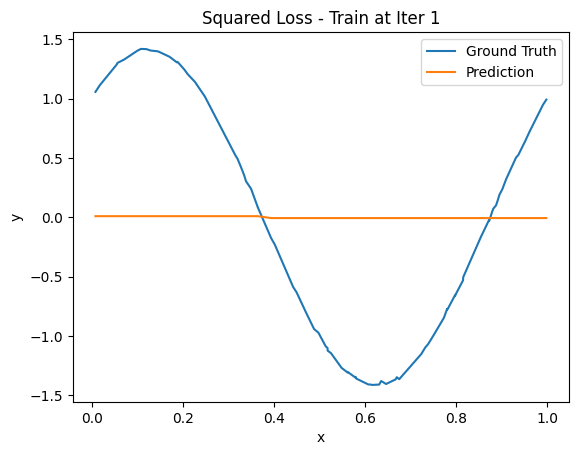

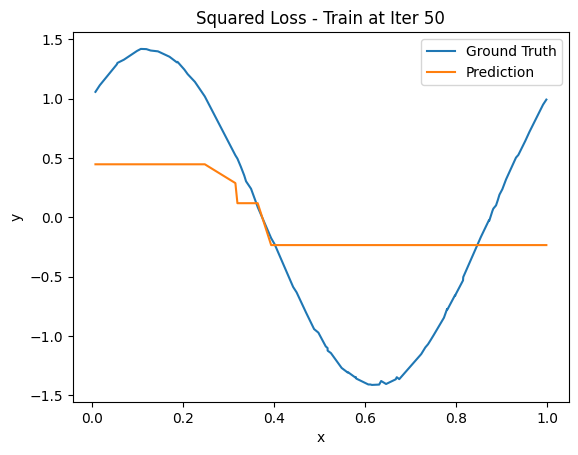

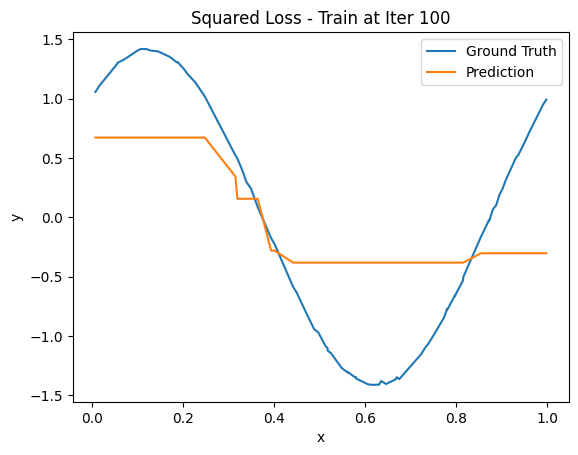

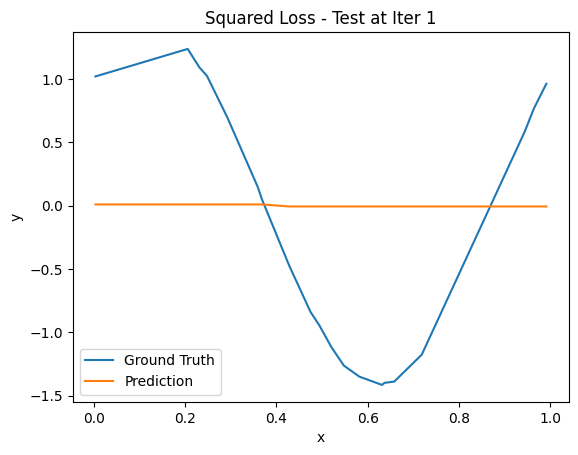

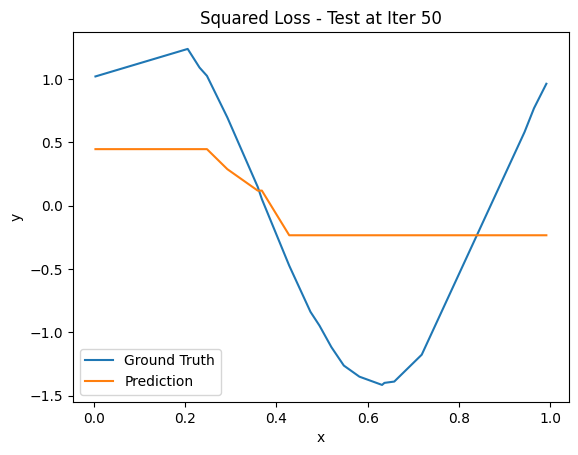

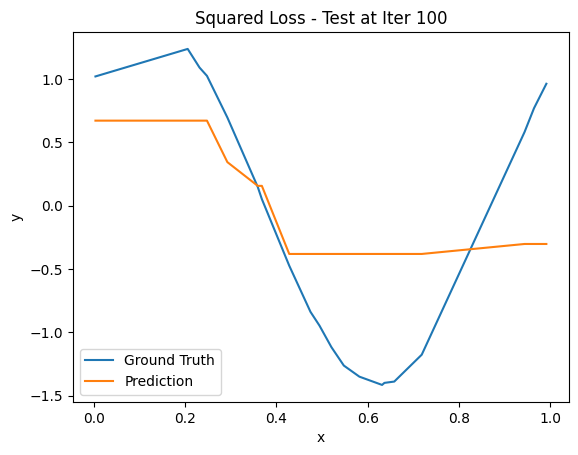

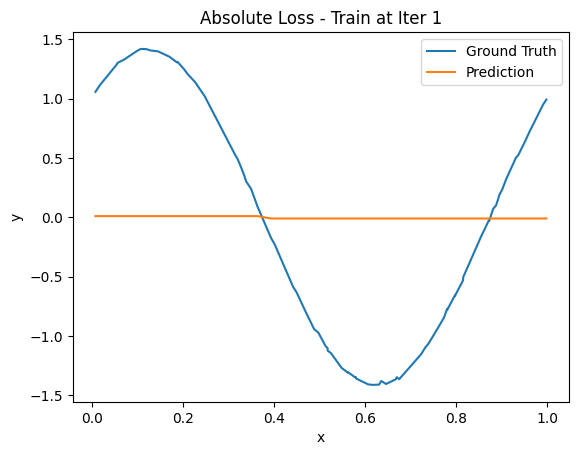

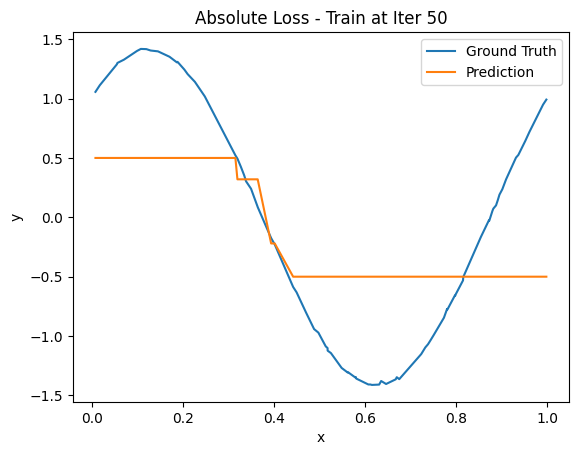

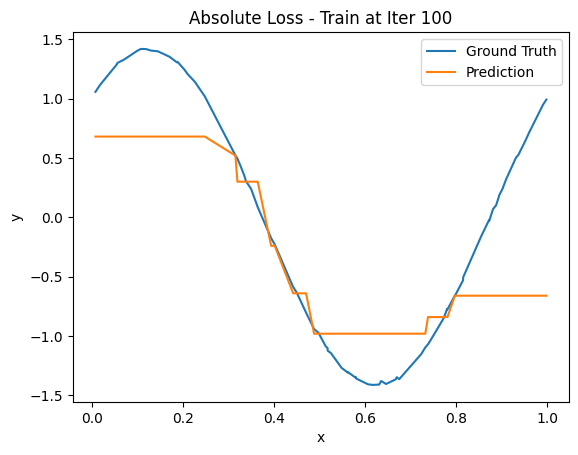

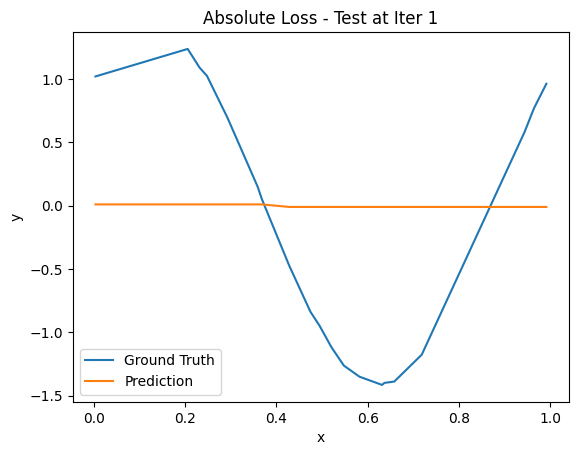

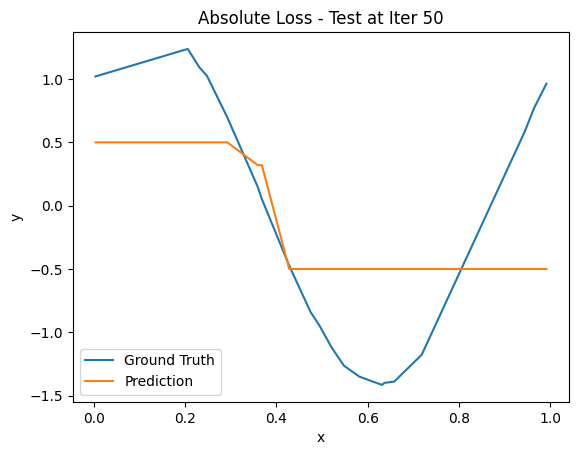

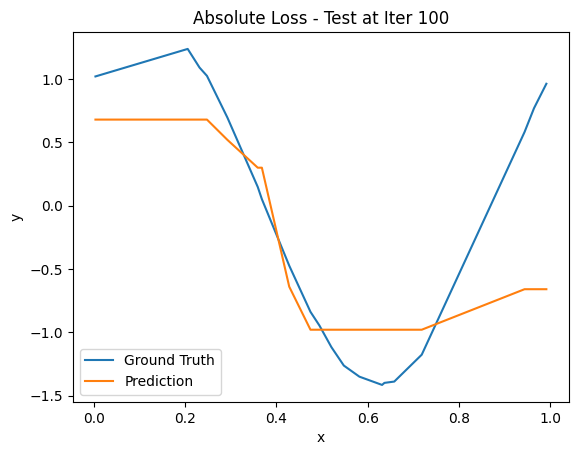

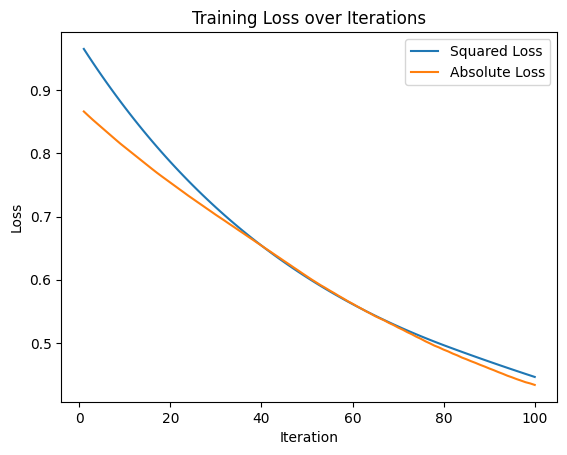

In [4]:
iterations = [1, 50, 100]
for loss_name, F_train_hist, F_test_hist in [
    ('Squared', F_train_sq, F_test_sq),
    ('Absolute', F_train_abs, F_test_abs)
]:
    for dataset, x_data, y_data, F_hist in [
        ('Train', x_train, y_train, F_train_hist),
        ('Test', x_test, y_test, F_test_hist)
    ]:
        for it in iterations:
            order = np.argsort(x_data)
            plt.figure()
            plt.plot(x_data[order], y_data[order], label='Ground Truth')
            plt.plot(x_data[order], F_hist[it-1][order], label='Prediction')
            plt.title(f'{loss_name} Loss - {dataset} at Iter {it}')
            plt.xlabel('x'); plt.ylabel('y')
            plt.legend()
            plt.show()

# %% [Cell 5]: Plot training loss over all iterations
plt.figure()
plt.plot(range(1, n_estimators+1), loss_sq, label='Squared Loss')
plt.plot(range(1, n_estimators+1), loss_abs, label='Absolute Loss')
plt.title('Training Loss over Iterations')
plt.xlabel('Iteration'); plt.ylabel('Loss')
plt.legend()
plt.show()